# Santander Product Prediction

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cross_validation import  train_test_split
from sklearn import metrics
from sklearn.cross_validation import KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from collections import defaultdict

C:\Users\Paris\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
df = pd.read_csv("santander.csv",dtype={"sexo":str,"ind_nuevo":str,"ult_fec_cli_1t":str,"indext":str})

C:\Users\Paris\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (5,8,11,15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df.isnull().sum()

fecha_dato                   0
ncodpers                     0
ind_empleado               109
pais_residencia            109
sexo                       109
age                          0
fecha_alta                 109
ind_nuevo                  109
antiguedad                   0
indrel                     109
ult_fec_cli_1t           49910
indrel_1mes                544
tiprel_1mes                544
indresi                    109
indext                     109
conyuemp                 49995
canal_entrada              683
indfall                    109
tipodom                    109
cod_prov                   340
nomprov                    340
ind_actividad_cliente      109
renta                    10375
segmento                   694
ind_ahor_fin_ult1            0
ind_aval_fin_ult1            0
ind_cco_fin_ult1             0
ind_cder_fin_ult1            0
ind_cno_fin_ult1             0
ind_ctju_fin_ult1            0
ind_ctma_fin_ult1            0
ind_ctop_fin_ult1            0
ind_ctpp

In [4]:
df.drop(["ult_fec_cli_1t", "conyuemp"], axis=1,inplace=True) 

In [5]:
# Change datatype
df["age"]   = pd.to_numeric(df["age"], errors="coerce") 
df["antiguedad"]   = pd.to_numeric(df["antiguedad"], errors="coerce") 
df["indrel_1mes"]   = pd.to_numeric(df["indrel_1mes"], errors="coerce") 

In [6]:
df.head()

,fecha_dato,ncodpers,ind_empleado,pais_residencia,sexo,age,fecha_alta,ind_nuevo,antiguedad,indrel,...,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
0,1/28/2015,1050622,N,ES,H,23.0,8/10/2012,0,35.0,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0
1,1/28/2015,1050492,N,ES,V,25.0,8/10/2012,0,35.0,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0
2,1/28/2015,1050571,N,ES,H,23.0,8/10/2012,0,35.0,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0
3,1/28/2015,1050915,N,ES,H,37.0,8/10/2012,0,35.0,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0
4,1/28/2015,1050732,N,ES,H,23.0,8/10/2012,0,35.0,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0


# *Data Cleaning*

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 46 columns):
fecha_dato               50000 non-null object
ncodpers                 50000 non-null int64
ind_empleado             49891 non-null object
pais_residencia          49891 non-null object
sexo                     49891 non-null object
age                      49891 non-null float64
fecha_alta               49891 non-null object
ind_nuevo                49891 non-null object
antiguedad               49891 non-null float64
indrel                   49891 non-null float64
indrel_1mes              49452 non-null float64
tiprel_1mes              49456 non-null object
indresi                  49891 non-null object
indext                   49891 non-null object
canal_entrada            49317 non-null object
indfall                  49891 non-null object
tipodom                  49891 non-null float64
cod_prov                 49660 non-null float64
nomprov                  49660 non-null 

Imputing missing values for income

In [8]:
grouped        = df.groupby("nomprov").agg({"renta":lambda x: x.median(skipna=True)}).reset_index()
new_incomes    = pd.merge(df,grouped,how="inner",on="nomprov").loc[:, ["nomprov","renta_y"]]
new_incomes    = new_incomes.rename(columns={"renta_y":"renta"})
df.sort_values("nomprov",inplace=True)
df             = df.reset_index()
new_incomes    = new_incomes.reset_index()

df.loc[df.renta.isnull(),"renta"] = new_incomes.loc[df.renta.isnull(),"renta"].reset_index()
df.loc[df.renta.isnull(),"renta"] = df.loc[df.renta.notnull(),"renta"].median()
df.sort_values(by="fecha_dato",inplace=True)

In [9]:
#Dropping rows which have missing values
df = df.dropna(axis=0)

In [10]:
#correcting age values that are negative
age_mean = df["antiguedad"].mean()
df[df["antiguedad"]<0]=age_mean

In [11]:
# Add a new column of the total number of products per customer per month
df["tot_products"] = df.loc[:,"ind_ahor_fin_ult1":"ind_recibo_ult1"].sum(axis=1)
df["tot_products"]   = pd.to_numeric(df["tot_products"], errors="coerce") 

In [12]:
#What country are the customers from?
df['pais_residencia'].describe() 

count     49072
unique        1
top          ES
freq      49072
Name: pais_residencia, dtype: object

Since everyone is from same location, we will drop this column.

In [13]:
df.drop("pais_residencia", axis=1, inplace = True)

In [14]:
df['ind_empleado'].value_counts()

N    49046
B       12
F        9
A        5
Name: ind_empleado, dtype: int64

In [15]:
#again dropping the column with low information
df.drop("ind_empleado",axis=1,inplace=True)

In [16]:
df.antiguedad = pd.to_numeric(df.antiguedad,errors="coerce")
df.ind_nomina_ult1 = pd.to_numeric(df.ind_nomina_ult1)
df.ind_nom_pens_ult1 = pd.to_numeric(df.ind_nom_pens_ult1)

In [17]:
#Let's confirm we have dealt with all missing values
df.isnull().values.any()

False


# *Visualisation*

In [18]:
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 12)

Populating the interactive namespace from numpy and matplotlib


Text(0,0.5,'Number of customers')

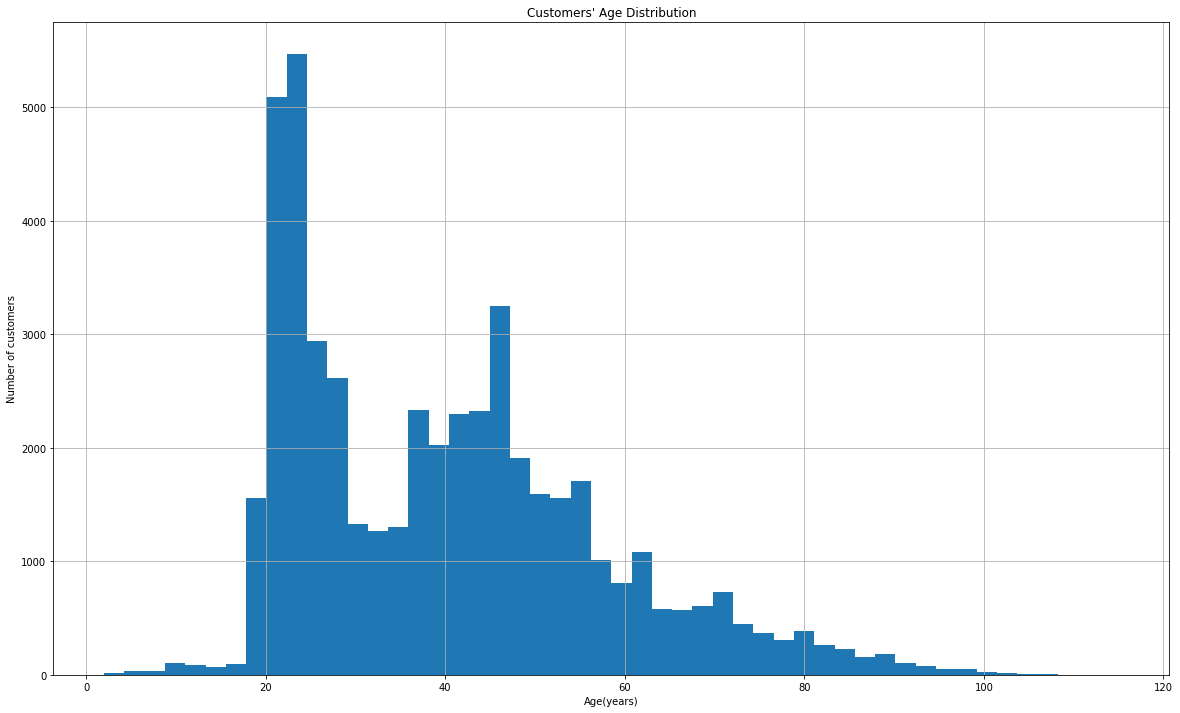

In [19]:
df['age'].hist(bins=50)
plt.title("Customers' Age Distribution")
plt.xlabel("Age(years)")
plt.ylabel("Number of customers") 

In [20]:
df.loc[df.age < 18,"age"]  = df.loc[(df.age >= 18) & (df.age <= 30),"age"].mean(skipna=True)
df.loc[df.age > 90,"age"] = df.loc[(df.age >= 30) & (df.age <= 90),"age"].mean(skipna=True)
df["age"].fillna(df["age"].mean(),inplace=True)
df["age"] = df["age"].astype(int)

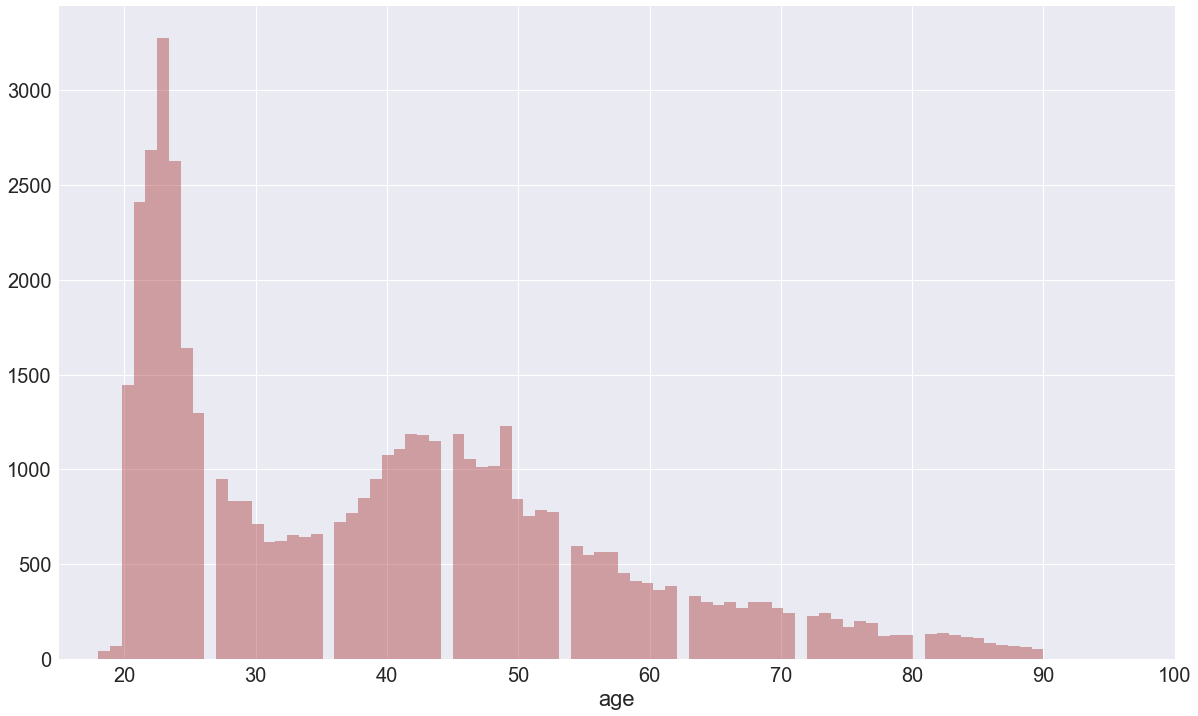

In [21]:
with sns.plotting_context("notebook",font_scale=2.0):
    sns.set_style("darkgrid")
    sns.distplot(df["age"].dropna(),bins=80,kde=False,color="brown")
    plt.xlim((15,100))

In [22]:
# Customers count by channel 
df['canal_entrada'].value_counts().head(15)

KHE    14760
KAT    11854
KFC    11301
KHQ     2213
KFA     1476
KHK      863
KHM      726
KHD      430
KHN      423
RED      302
KAG      301
KAS      276
KAY      261
KAA      240
KAB      226
Name: canal_entrada, dtype: int64

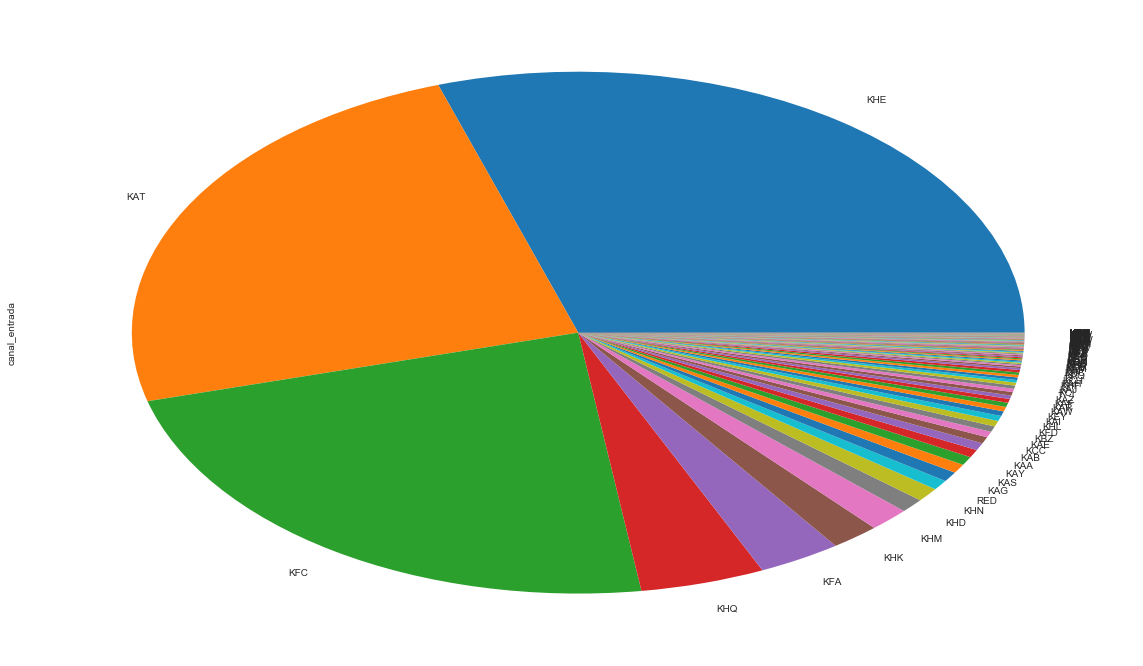

In [23]:
df["canal_entrada"].value_counts().plot(x=None, y=None, kind='pie', ) 

We observe 3 major Channels and top 6 Channels contribute about 87% of customer attractions. There are 129 unique channels.

In [24]:
# No of customers by activity index and gender
df_a = df.loc[:, ['sexo', 'ind_actividad_cliente']].join(df.loc[:, "ind_ahor_fin_ult1": "ind_recibo_ult1"])
df_a = df_a.groupby(['sexo', 'ind_actividad_cliente']).sum()
df_a = df_a.T

In [25]:
df_a.head()

sexo                        H               V        
ind_actividad_cliente     0.0     1.0     0.0     1.0
ind_ahor_fin_ult1         1.0     0.0     2.0     1.0
ind_aval_fin_ult1         0.0     0.0     0.0     0.0
ind_cco_fin_ult1       7998.0  7286.0  7456.0  9486.0
ind_cder_fin_ult1         2.0     3.0     1.0    17.0
ind_cno_fin_ult1         26.0  1610.0    29.0  2348.0

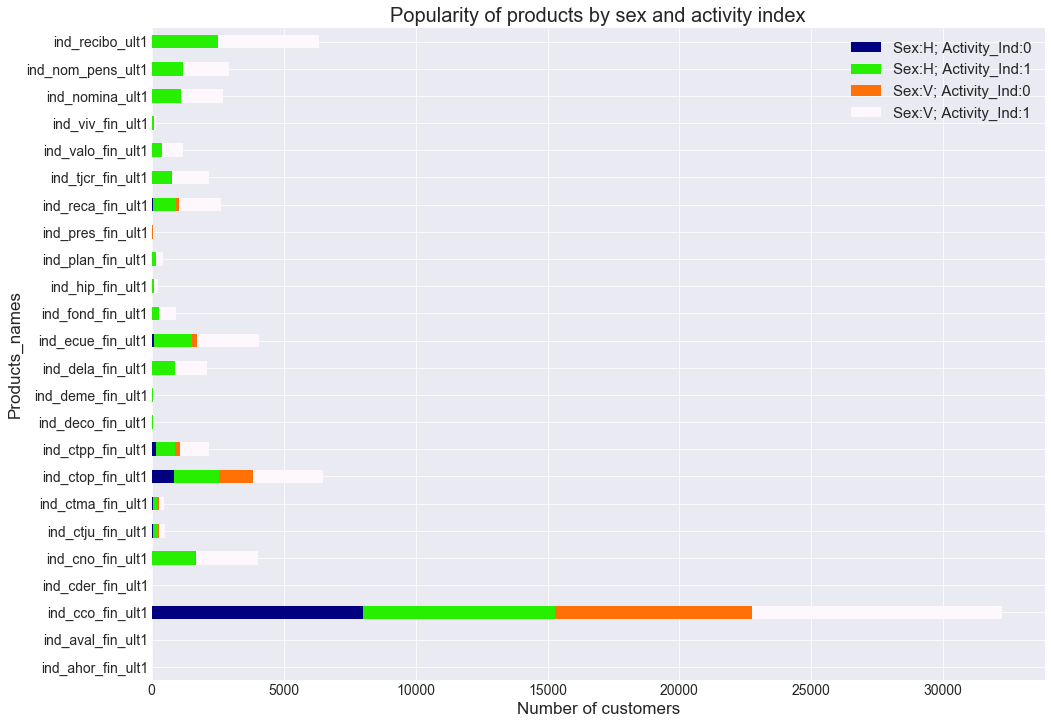

In [26]:
df_a.plot(kind='barh', stacked=True, fontsize=14, figsize=[16,12], colormap='gist_ncar')
plt.title('Popularity of products by sex and activity index', fontsize=20) 
plt.xlabel('Number of customers', fontsize=17) 
plt.ylabel('Products_names', fontsize=17) 
plt.legend(["Sex:H; Activity_Ind:0", "Sex:H; Activity_Ind:1", "Sex:V; Activity_Ind:0", 
            "Sex:V; Activity_Ind:1"], prop={'size':15}) 

Excluding the most common product, **current account** *(ind_cco_fin_ult1)*, so as to get a better understanding of other distributions.

In [27]:
df_a.drop("ind_cco_fin_ult1",axis=0,inplace=True)

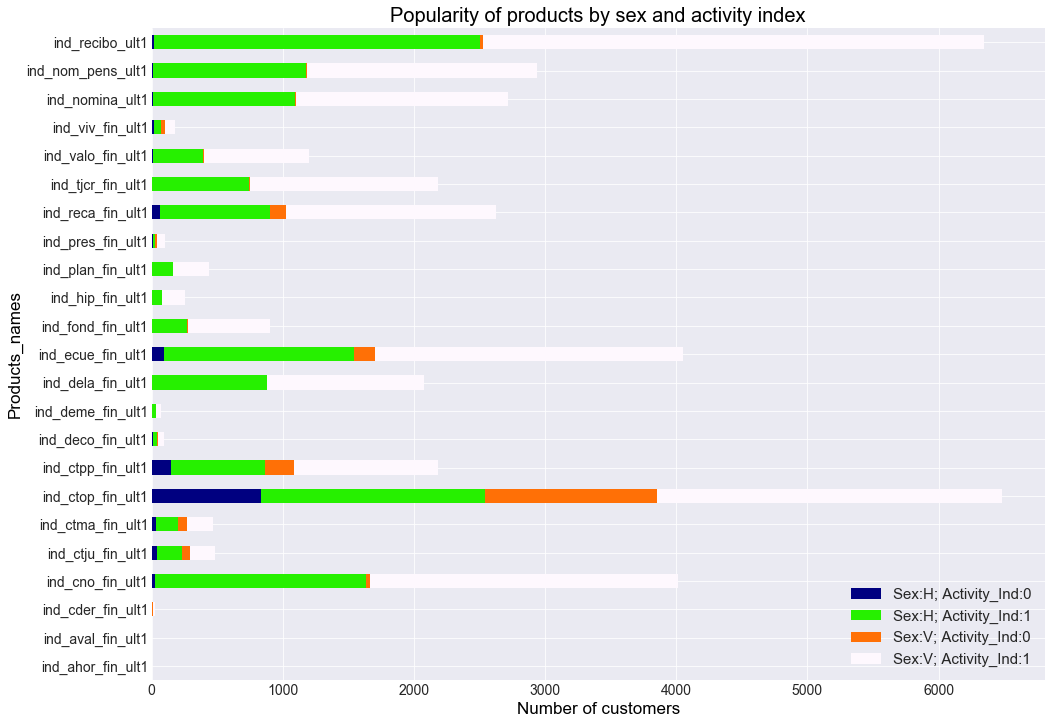

In [28]:
df_a.plot(kind='barh', stacked=True, fontsize=14, figsize=[16,12], colormap='gist_ncar')
plt.title('Popularity of products by sex and activity index', fontsize=20, color='black') 
plt.xlabel('Number of customers', fontsize=17, color='black') 
plt.ylabel('Products_names', fontsize=17, color='black') 
plt.legend(["Sex:H; Activity_Ind:0", "Sex:H; Activity_Ind:1", "Sex:V; Activity_Ind:0", 
            "Sex:V; Activity_Ind:1"], prop={'size':15})

In [29]:
#Total number of products per customer
df["tot_products"].value_counts()

1.0     25827
0.0      9021
2.0      7009
3.0      2839
4.0      1589
5.0      1090
6.0       751
7.0       472
8.0       292
9.0       112
10.0       47
11.0       17
12.0        6
Name: tot_products, dtype: int64

Most customers are using upto 2 products. About 15% customers use 3 or more products.

In [30]:
# Let's bin the income and see if salary has a relation with the total number of products bought
df_a = (df.groupby(pd.cut(df['renta'], [0,60000,120000,180000,240000, pd.np.inf], right=False)).sum())

In [31]:
df_a["tot_products"]

renta
[0.0, 60000.0)           9087.0
[60000.0, 120000.0)     35466.0
[120000.0, 180000.0)    14583.0
[180000.0, 240000.0)     6407.0
[240000.0, inf)          6508.0
Name: tot_products, dtype: float64

In [32]:
#Working with only the product columns
df_a = df_a.loc[:, "ind_ahor_fin_ult1": "ind_recibo_ult1"]
df_a = df_a.T

In [33]:
df_a.drop("ind_cco_fin_ult1",axis=0,inplace=True)

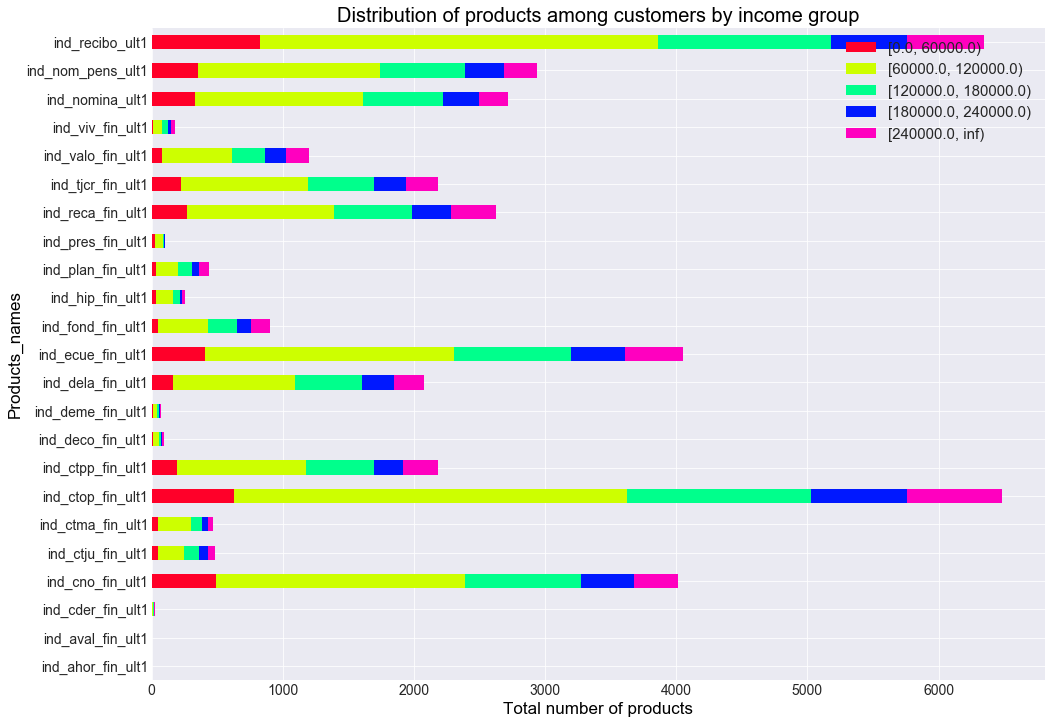

In [34]:
df_a.plot(kind='barh', stacked=True, fontsize=14, figsize=[16,12], colormap='gist_rainbow')
plt.title('Distribution of products among customers by income group', fontsize=20, color='black') 
plt.xlabel('Total number of products', fontsize=17, color='black') 
plt.ylabel('Products_names', fontsize=17, color='black') 
plt.legend(prop={'size':15}, loc=1) 

In [35]:
# Let us look at the relation between product channel and products
df_a = df.loc[:, ['canal_entrada']].join(df.loc[:, 'ind_ahor_fin_ult1':'ind_recibo_ult1'])

In [36]:
top_5 = ["KHE", "KAT", "KFC", "KFA", "KHK"]

In [37]:
df_a = df_a.loc[df_a['canal_entrada'].isin(top_5)]

In [38]:
df_a = df_a.groupby("canal_entrada").agg("sum")
df_a = df_a.T

In [39]:
df_a.drop("ind_cco_fin_ult1",axis=0,inplace=True)

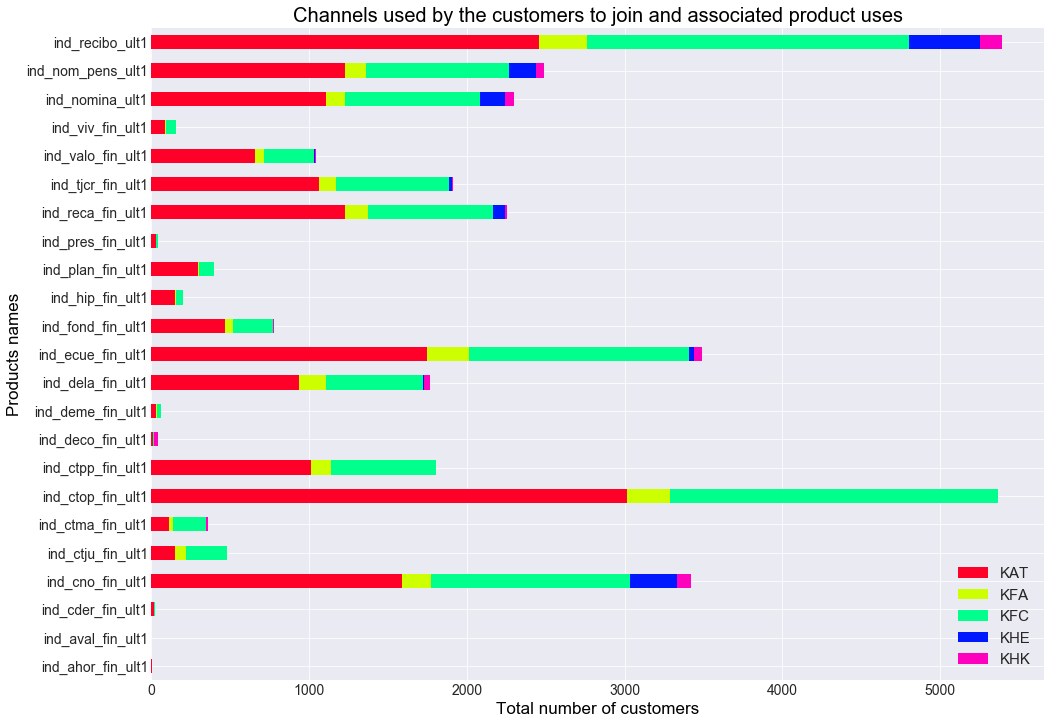

In [40]:
df_a.plot(kind='barh', stacked=True, fontsize=14, figsize=[16,12], colormap='gist_rainbow')
plt.title('Channels used by the customers to join and associated product uses', fontsize=20, color='black') 
plt.xlabel('Total number of customers', fontsize=17, color='black') 
plt.ylabel('Products names', fontsize=17, color='black') 
plt.legend(prop={'size':15})

Let us inspect customer behaviour, we will look at customers who have bought products other than the current account.

In [41]:
# Distribution of product groups by age
df_a = df.loc[:, ['age']].join(df.loc[:, 'ind_ahor_fin_ult1':'ind_recibo_ult1'])

In [42]:
df_a = (df_a.groupby(pd.cut(df_a['age'], [0,18,25,35,45,55, pd.np.inf], right=False)).sum())

In [43]:
df_a = df_a.T

In [44]:
df_a = df.loc[:,["age"]].join(df.loc[:, 'ind_ahor_fin_ult1':'ind_recibo_ult1'])

In [45]:
fnc = {c:'sum' for c in df_a.columns.drop(['age']).tolist()}
fnc['age'] = 'mean'

In [46]:
df_a = df_a.groupby('age').agg(fnc).reindex_axis(df_a.columns.drop('age'), 1) 

C:\Users\Paris\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
  """Entry point for launching an IPython kernel.


In [47]:
df_a.head()

,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,ind_cder_fin_ult1,ind_cno_fin_ult1,ind_ctju_fin_ult1,ind_ctma_fin_ult1,ind_ctop_fin_ult1,ind_ctpp_fin_ult1,ind_deco_fin_ult1,...,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
age,,,,,,,,,,,,,,,,,,,,,
18,0.0,0.0,1.0,0.0,0.0,39.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19,0.0,0.0,25.0,0.0,0.0,36.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20,0.0,0.0,1031.0,0.0,14.0,5.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,16.0
21,0.0,0.0,1928.0,0.0,37.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,4.0,2.0,2.0,0.0,18.0,21.0,64.0
22,0.0,0.0,2188.0,0.0,46.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,7.0,7.0,1.0,0.0,22.0,25.0,108.0


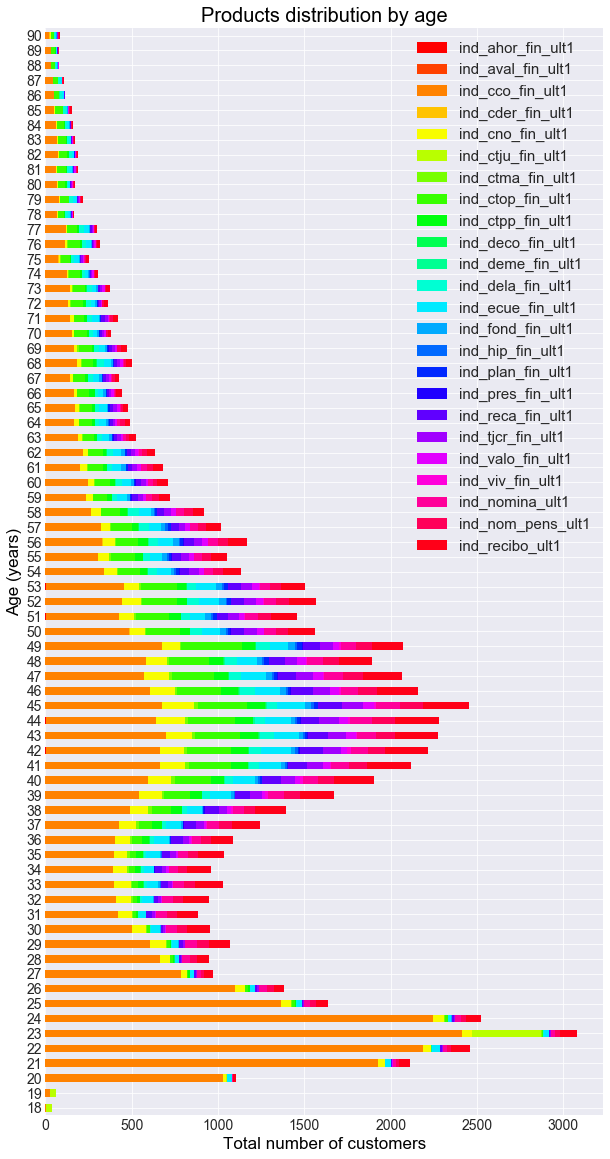

In [48]:
# Products distribution by age
df_a.plot(kind='barh', stacked=True, fontsize=14, figsize=[10,20], colormap='hsv')
plt.title('Products distribution by age', fontsize=20, color='black') 
plt.xlabel('Total number of customers', fontsize=17, color='black') 
plt.ylabel('Age (years)', fontsize=17, color='black') 
plt.legend(prop={'size':15}) 

In [49]:
df.drop(["tipodom"],axis=1,inplace=True)

In [50]:
incomes = df.loc[df.renta.notnull(),:].groupby("nomprov").agg({"renta":{"MedianIncome":median}})
incomes.sort_values(by=("renta","MedianIncome"),inplace=True)
incomes.reset_index(inplace=True)
incomes.nomprov = incomes.nomprov.astype("category", categories=[i for i in df.nomprov.unique()],ordered=False)
incomes.head()

C:\Users\Paris\Anaconda3\lib\site-packages\pandas\core\groupby.py:4291: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)
C:\Users\Paris\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  after removing the cwd from sys.path.


,nomprov,renta
,,MedianIncome
0,BIZKAIA,67183.980
1,AVILA,68041.725
2,BADAJOZ,68854.740
3,CIUDAD REAL,69181.200
4,"BALEARS, ILLES",71063.415


([<matplotlib.axis.YTick at 0x1dc95f95828>,
 <a list of 5 Text yticklabel objects>)

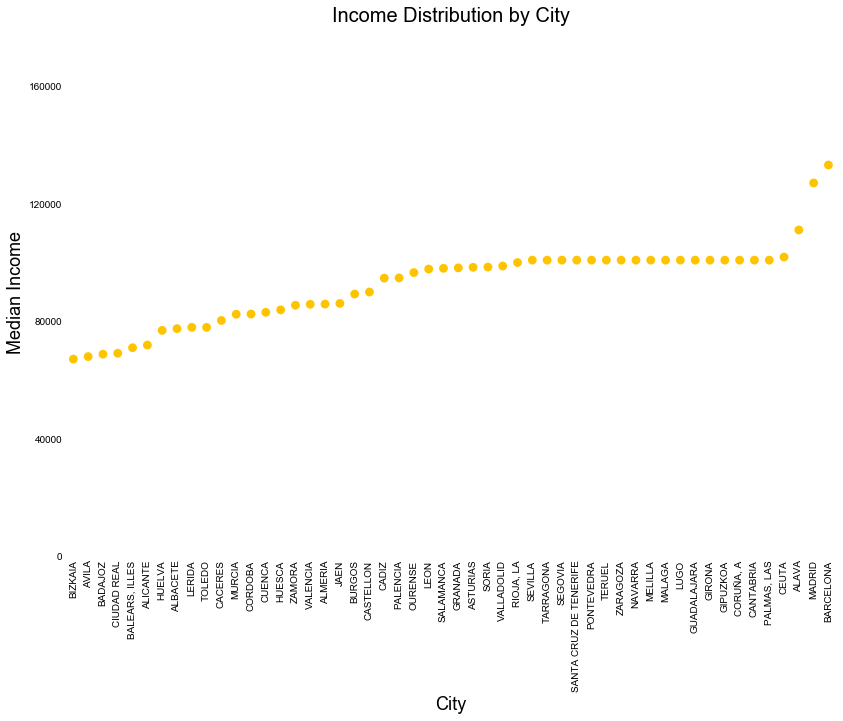

In [51]:
with sns.axes_style({
        "axes.facecolor":   "white",
        "axes.grid"     :    False,
        "figure.facecolor": "white"}):
    h = sns.factorplot(data=incomes,
                   x="nomprov",
                   y=("renta","MedianIncome"),
                   order=(i for i in incomes.nomprov),
                   size=8,
                   aspect=1.5,
                   scale=1.0,
                   color="#ffc400",
                   linestyles="None")
plt.xticks(rotation=90)
plt.tick_params(labelsize=10,labelcolor="black")#
plt.ylabel("Median Income",size=18,color="black")
plt.xlabel("City",size=18,color="black")
plt.title("Income Distribution by City",size=20,color="black")
plt.ylim(0,180000)
plt.yticks(range(0,180000,40000))

In [52]:
df.drop(["nomprov"],axis=1,inplace=True)

In [53]:
feature_cols = df.iloc[:1,].filter(regex="ind_+.*ult.*").columns.values
for col in feature_cols:
    df[col] = df[col].astype(int)

In [54]:
usecols = ['ncodpers', 'ind_ahor_fin_ult1', 'ind_aval_fin_ult1', 'ind_cco_fin_ult1',
       'ind_cder_fin_ult1', 'ind_cno_fin_ult1', 'ind_ctju_fin_ult1',
       'ind_ctma_fin_ult1', 'ind_ctop_fin_ult1', 'ind_ctpp_fin_ult1',
       'ind_deco_fin_ult1', 'ind_deme_fin_ult1', 'ind_dela_fin_ult1',
       'ind_ecue_fin_ult1', 'ind_fond_fin_ult1', 'ind_hip_fin_ult1',
       'ind_plan_fin_ult1', 'ind_pres_fin_ult1', 'ind_reca_fin_ult1',
       'ind_tjcr_fin_ult1', 'ind_valo_fin_ult1', 'ind_viv_fin_ult1',
       'ind_nomina_ult1', 'ind_nom_pens_ult1', 'ind_recibo_ult1']

In [55]:
df_train= pd.read_csv("santander.csv",dtype={"sexo":str,
                                         "ind_nuevo":str,
                                         "ult_fec_cli_1t":str,
                                          "indext":str},usecols=usecols)

In [56]:
df_train = df_train.drop_duplicates(['ncodpers'], keep='last')

In [57]:
df_train.fillna(0, inplace=True)

In [58]:
unique_ids   = pd.Series(df_train["ncodpers"].unique())

In [59]:
sample = pd.read_csv('sample_submission.csv')

In [60]:
limit_people = 10000
unique_id    = unique_ids.sample(n=limit_people)

In [61]:
models = {}
id_preds = defaultdict(list)
ids = df_train['ncodpers'].values

#Delete in final model (Done before)
feature_cols = df.iloc[:1,].filter(regex="ind_+.*ult.*").columns.values
for col in feature_cols:
    df[col] = df[col].astype(int)

In [62]:
for c in df_train.columns:
    if c != 'ncodpers':
        #print(c)
        y_train = df_train[c]
        x_train = df_train.drop([c, 'ncodpers'], 1)

In [63]:
clf = LogisticRegression()
clf.fit(x_train, y_train)
p_train = clf.predict_proba(x_train)[:,1]

In [64]:
models[c] = clf
for id, p in zip(ids, p_train):
      id_preds[id].append(p)
            
print(roc_auc_score(y_train, p_train))

0.8625554325121124


In [65]:
from sklearn import ensemble
clf2 = ensemble.ExtraTreesClassifier(n_estimators = 35, n_jobs = -1, max_depth = 12)
clf2.fit(x_train, y_train)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=12, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=35, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [66]:
p_train3 = clf2.predict_proba(x_train)[:,1]

In [67]:
models[c] = clf2
for id, p in zip(ids, p_train3):
      id_preds[id].append(p)
print(roc_auc_score(y_train, p_train3))

0.86824100596482


In [68]:
clf1 = ensemble.RandomForestClassifier(n_estimators=120, n_jobs=-1 , max_depth=60, min_samples_split=10, verbose=1)
clf1.fit(x_train, y_train)
p_train1 = clf1.predict_proba(x_train)[:,1]

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    1.7s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 out of 120 | elapsed:    0.4s finished


In [69]:
models[c] = clf1
for id, p in zip(ids, p_train1):
      id_preds[id].append(p)           
print(roc_auc_score(y_train, p_train1))

0.869050954807825
